<div align='center'><img src='model_income.jpeg' width=480/></div>

# Прогноз дохода клиентов

 - Задача прогнозирования дохода имеет особенное значение в Банке. 
Эта информация помогает точнее и более релевантно подбирать продукты и условия их приобретения, что в свою очередь вносит существенный вклад в прибыль Банка. 
 - Помимо ценности для Банка, оценка дохода является регуляторным требованием ЦБ в части расчета предельно допустимой кредитной нагрузки для клиента (далее ПДН)
 
# Данные
- train.csv обучающая выборка
- test.csv выборка для скоринга
- description.xlsx - описание признаков

# Метрика качества
<a href='https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html'>WMAE</a> - Взвешенная средняя абсолютная ошибка

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import catboost
from catboost import CatBoostRegressor

#import optuna
#from optuna.samplers import TPESampler

from faiss_imputer import FaissImputer

from tqdm import tqdm

In [2]:
def weighted_mean_absolute_error(y_true, y_pred, weights):

    '''

    Weighted mean absolute error.

    Parameters
    ----------
    y_true: ndarray
        Ground truth
    y_pred: ndarray
        Array of predictions

    Returns
    -------
    rmsle: float
        Weighted mean absolute error

    References
    ----------
    .. [1] https://kaggle-metrics.readthedocs.io/en/latest/_modules/kaggle_metrics/regression.html

    '''
    
    return (weights * np.abs(y_true - y_pred)).mean()

In [8]:
train_df = pd.read_csv('train_df_2.csv')
test_df = pd.read_csv('test_df_2.csv')
train_df.shape, test_df.shape

((205962, 241), (37183, 239))

In [4]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
train_df.groupby('feature_date')['target'].agg('mean')

feature_date
2022-09-30    114287.320165
2022-10-31    117879.133873
2022-11-30    126371.360007
2022-12-31     93871.407604
2023-01-31     95479.958552
2023-02-28     96830.174003
2023-03-31     98017.820189
2023-04-30    132242.099857
2023-05-31     67519.921212
2023-06-30     91897.858128
2023-07-31     97319.320066
2023-08-31    102141.949651
Name: target, dtype: float64

In [12]:
reg_incomes = {
    'Свердловская область' : 55310,
    'Новосибирская область' : 53760,
    'Московская область' : 70710,
    'Краснодарский край' : 50250,
    'Ростовская область' : 44770,
    'г. Москва' : 125640,
    'Красноярский край' : 71730,
    'Республика Карелия' : 56460,
    'г. Санкт - Петербург' : 86630,
    'Мурманская область' : 87330,
    'Оренбургская область' : 43540,
    'Воронежская область' : 46280,
    'Кемеровская область - Кузбасс' : 57650,
    'Ханты-Мансийский автономный окр.' : 97560,
    'Тюменская область' : 94960,
    'Алтайский край' : 39720,
    'Республика Башкортостан' : 49460,
    'Хабаровский край' : 65900,
    'Республика Татарстан (Татарстан)' : 52270,
    'Калининградская область' : 47350,
    'Пермский край' : 53230,
    'Удмуртская Республика' : 45810,
    'Чувашская Республика - Чувашия' : 41530,
    'Ивановская область' : 36380,
    'Самарская область' : 48870,
    'Нижегородская область' : 48370,
    'Иркутская область' : 64640,
    'Волгоградская область' : 44240,
    'Ставропольский край' : 41400,
    'Ярославская область' : 47390,
    'Саратовская область' : 42920,
    'Челябинская область' : 50100,
    'Томская область' : 57880,
    'Омская область' : 46950,
    'Пензенская область' : 41310,
    'Липецкая область' : 46710,
    'Курская область' : 46060,
    'Приморский край' : 63590,
    'Республика Мордовия' : 39540,
    'Владимирская область' : 45680,
    'Ульяновская область' : 41520,
    'Калужская область' : 53910,
    'Архангельская область' : 67840,
    'Курганская область' : 41790,
    'Республика Хакасия' : 54520,
    'Псковская область' : 38970,
    'Республика Саха (Якутия)' : 96730,
    'Белгородская область' : 47640,
    'Сахалинская область' : 102680,
    'Тульская область' : 51220,
    'Рязанская область' : 45770,
    'Тверская область' : 45730,
    'Республика Марий Эл' : 40710,
    'Кировская область' : 40830,
    'Республика Коми' : 68790,
    'Брянская область' : 40800,
    'Тамбовская область' : 39350,
    'Орловская область' : 40840,
    'Республика Калмыкия' : 36350,
    np.NaN : np.NaN
}

In [13]:
train_df['mean_addrref_income'] = train_df['addrref'].apply(lambda x: reg_incomes[x])

,client_id,feature_date,target,w,accum_rur_amt_cm_avg_div_v2,addrref,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__bilety_na_kontserty_i_v_teatry,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__brokerskie_uslugi,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__hosting,amount_by_category_30d__summarur_amt__sum__cashflowcategory_name__spa_sauny_bani,...,voc_features_full_mark_eq_3_flag,worksalary_rur_amt,brand,model,productionyear,usd_price,prime_rate,infl,amount_of_money,mean_addrref_income
0,0,2023-06-30,150000.000000,0.681495,0.000000,Свердловская область,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,89.5500,7.5,3.25,17538.9,55310.0
1,1,2023-01-31,96845.573333,0.085636,1.000000,Новосибирская область,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,69.8200,7.5,11.77,16454.7,53760.0
2,2,2023-03-31,60906.061667,0.317245,1.000000,Новосибирская область,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,77.5975,7.5,3.51,16616.3,53760.0
3,3,2023-02-28,65272.380000,0.268299,1.000000,Московская область,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,74.9700,7.5,10.99,16274.8,70710.0
4,4,2023-05-31,43999.770000,0.506764,1.000000,Краснодарский край,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,81.1025,7.5,2.51,17349.8,50250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205957,208026,2022-11-30,60244.400000,0.324662,0.409200,г. Санкт - Петербург,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,60.9900,7.5,11.98,15596.4,86630.0
205958,208027,2023-07-31,120000.000000,0.345196,1.000000,Краснодарский край,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,91.6025,8.5,4.30,17998.0,50250.0
205959,208028,2022-09-30,385859.490000,2.362991,1.012048,г. Москва,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,58.4500,7.5,13.68,14335.4,125640.0
205960,208029,2022-11-30,94347.710000,0.057635,1.000000,Воронежская область,NaN,NaN,NaN,NaN,...,0.0,90000.0,NaN,NaN,NaN,60.9900,7.5,11.98,15596.4,46280.0


In [74]:
test_df['mean_addrref_income'] = test_df['addrref'].apply(lambda x: reg_incomes[x])

In [79]:
train_df.to_csv('train_df_2')
test_df.to_csv('test_df_2')

In [20]:
df = pd.concat([train_df.drop(['w', 'target'], axis=1), test_df], sort=False, ignore_index=True)

In [21]:
cur_cat_feat = train_df.select_dtypes(include=['object']).columns.to_numpy()

In [22]:
num_feat = []
for col in df.columns:
    if col not in cur_cat_feat:
        num_feat.append(col)

In [23]:
num_df = df[num_feat]

In [24]:
num_df.shape

(243145, 226)

In [25]:
for col in num_df:
    if num_df[col].isna().sum() / num_df.shape[0] > 0.5:
        num_df.drop(col, axis=1, inplace=True)

C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplac

C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplac

C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplac

C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplac

C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplac

C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_14396\1296586288.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df.drop(col, axis=1, inplac

In [26]:
num_df.shape

(243145, 67)

In [27]:
#imputer = FaissImputer(3)
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
df_imputed = my_imputer.fit_transform(num_df)

In [28]:
#imputer.fit(num_df)

In [29]:
#df_imputed = imputer.transform(num_df)

In [30]:
#df_imputed = imputer.transform(df_imputed)

In [31]:
i = 0
for col in num_df.columns:
    num_df[col] = df_imputed.T[i]
    i += 1

C:\Users\hd\AppData\Local\Temp\ipykernel_14396\2682791051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df[col] = df_imputed.T[i]


In [33]:
for col in df.columns:
    if col in num_df.columns:
        df[col] = num_df[col]
    #elif col not in cur_cat_feat:
    #    df.drop([col], axis=1, inplace=True)

In [35]:
train_df_no = df[:205962]
test_df_no = df[205962:]
train_df_no.shape, test_df_no.shape

((205962, 237), (37183, 237))

In [36]:
train_df = pd.concat([train_df_no, train_df[['w', 'target']]], axis=1, join='inner')

In [37]:
test_df = test_df_no

In [38]:
train_df.to_csv('train_imputed_sk_50.csv')
test_df.to_csv('test_imputed_sk_50.csv')

In [39]:
train_df.isna().sum().sum()

30730190

In [24]:
test = pd.read_csv('train_df.csv')

In [25]:
test.isna().sum().sum()

33712729

In [37]:
selected_features = ['segment', 'avg_debet_turn_rur', 'worksalary_rur_amt',
       'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
       'hdb_bki_total_pil_max_limit', 'hdb_bki_total_max_limit', 'month',
       'max_pil_largest_max_limit_actoff_90d',
       'max_cc_largest_max_limit_actoff_30d', 'curr_rur_amt_cm_avg',
       'hdb_bki_total_cc_max_limit', 'min_max_limit',
       'avg_6m_money_transactions', 'incomeValue', 'hdb_outstand_sum',
       'addrref', 'oldest_campaignsegment_ccode_for_nss',
       'amount_of_money', 'turn_other_db_max_v2', 'first_salary_income',
       'hdb_bki_total_max_overdue_sum',
       'total_rur_amt_cm_avg_period_days_ago_v2',
       'oldest_campaignsegment_ccode_for_pil',
       'transaction_category_supermarket_sum_amt_m3_4', 'usd_price',
       'mob_cnt_days', 'avg_6m_transportation',
       'channel_mobilnoe_prilozhenie_am_voc_features_12m_voc_with_expert_cnt',
       'avg_percents_inc', 'hdb_bki_active_ip_max_outstand',
       'turn_other_cr_avg_v2', 'avg_cnt_daily_transactions_90d',
       'avg_by_category__amount__sum__cashflowcategory_name__zdorove',
       'profit_income_out_rur_amt_9m', 'min_pil_max_score_actoff_180d',
       'hdb_bki_active_pil_max_overdue', 'total_rur_amt_cm_avg_div_v2',
       'by_category__amount__sum__eoperation_type_name__vneshnij_perevod_rur',
       'avg_6m_building_services', 'main_last_position_ccode',
       'accum_rur_amt_cm_avg_div_v2', 'uniV5',
       'transaction_category_supermarket_sum_cnt_d15',
       'avg_6m_personal_services', 'prof_cc_prof',
       'hdb_bki_active_cc_cnt', 'turn_cc_cr_max_v2', 'avg_3m_hotels',
       'min_cc_max_el_actoff_90d', 'commission_outcome_rur_amt',
       'percent_outcome_rur_amt', 'infl', 'mob_cover_days',
       'hdb_bki_other_active_auto_month_payments_sum', 'smsInWavg6m',
       'avg_by_category__amount__sum__cashflowcategory_name__detskie_igrushki',
       'summarur_1m_no_cat', 'atravel', 'turn_cc_db_min_v2', 'staff_flag',
       'puupg_offer_exists_pass_180d',
       'transaction_category_hotels_sum_amt_m2', 'mean_addrref_income']

In [39]:
np.unique(train_df['feature_date'].to_numpy())

array(['2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
       '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
       '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31'],
      dtype=object)

In [40]:
np.unique(test_df['feature_date'].to_numpy())

array(['2023-09-30'], dtype=object)

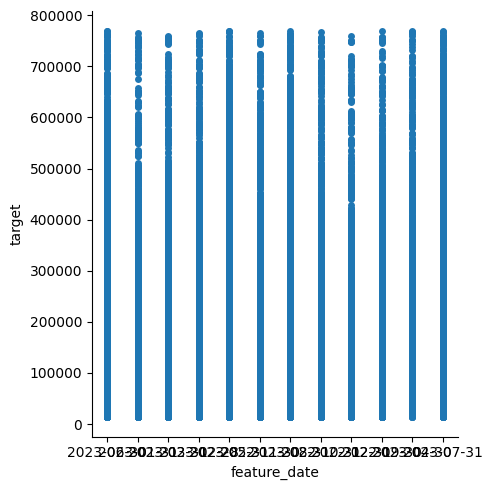

In [41]:
sns.catplot(x='feature_date', y='target', data=train_df, jitter=False)

In [42]:
#train_df['bki_total_ip_max_limit'] = pd.to_numeric(train_df['bki_total_ip_max_limit'])

In [43]:
'''
for col in train_df.columns:
    if col[:3] == 'hdb':
        train_df[col] = pd.to_numeric(train_df[col])
''';

In [44]:
'''
test_df['bki_total_ip_max_limit'] = pd.to_numeric(test_df['bki_total_ip_max_limit'])
for col in test_df.columns:
    if col[:3] == 'hdb':
        test_df[col] = pd.to_numeric(test_df[col])
''';

In [45]:
train_df['target'].mean()

94411.9066652809

In [46]:
train_df.groupby('segment')['client_id'].agg('count')

segment
Affluent         20969
Mass             72246
Mass Affluent    76394
Name: client_id, dtype: int64

In [47]:
train_df.groupby('segment')['target'].agg('mean')

segment
Affluent         228806.119130
Mass              62020.361695
Mass Affluent     94845.341776
Name: target, dtype: float64

In [49]:
train_df.groupby('feature_date')['target'].agg('mean')

feature_date
2022-09-30    114287.320165
2022-10-31    117879.133873
2022-11-30    126371.360007
2022-12-31     93871.407604
2023-01-31     95479.958552
2023-02-28     96830.174003
2023-03-31     98017.820189
2023-04-30    132242.099857
2023-05-31     67519.921212
2023-06-30     91897.858128
2023-07-31     97319.320066
2023-08-31    102141.949651
Name: target, dtype: float64

In [14]:
train_df['target'].mean()

94411.9066652809

In [50]:
train_df['year'] = train_df['feature_date'].apply(lambda x: int(x[:4]))
train_df['month'] = train_df['feature_date'].apply(lambda x: int(x[6:7]))

test_df['year'] = test_df['feature_date'].apply(lambda x: int(x[:4]))
test_df['month'] = test_df['feature_date'].apply(lambda x: int(x[6:7]))

In [51]:
val_df = train_df[train_df['feature_date'] == '2023-08-31']
train_df = train_df[train_df['feature_date'] != '2023-08-31']

In [52]:
train_df.drop('feature_date', axis=1, inplace=True)
val_df.drop('feature_date', axis=1, inplace=True)
test_df.drop('feature_date', axis=1, inplace=True)

C:\Users\hd\AppData\Local\Temp\ipykernel_18784\3345780538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop('feature_date', axis=1, inplace=True)
C:\Users\hd\AppData\Local\Temp\ipykernel_18784\3345780538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df.drop('feature_date', axis=1, inplace=True)


In [53]:
val_df.shape[0] / (train_df.shape[0] + val_df.shape[0])

0.1249647993319156

In [54]:
train_df = train_df[selected_features + ['target', 'w', 'client_id']]
test_df = test_df[selected_features + ['client_id']]
val_df = val_df[selected_features + ['target', 'w', 'client_id']]

In [55]:
cat_feat = train_df.select_dtypes(include=['object']).columns.to_numpy()

In [56]:
cat_feat

array(['segment', 'addrref', 'oldest_campaignsegment_ccode_for_nss',
       'oldest_campaignsegment_ccode_for_pil', 'main_last_position_ccode'],
      dtype=object)

In [57]:
for feature in cat_feat: #cat_feat
    test_df[feature] = test_df[feature].fillna('no_data')
    train_df[feature] = train_df[feature].fillna('no_data')
    val_df[feature] = val_df[feature].fillna('no_data')

In [58]:
X_train = train_df.drop(['target', 'w', 'client_id'], axis=1)
y_train = train_df['target']
X_val = val_df.drop(['target', 'w', 'client_id'], axis=1)
y_val = val_df['target']

In [59]:
val_weights = val_df['w']

In [60]:
y_train

0         150000.000000
1          96845.573333
2          60906.061667
3          65272.380000
4          43999.770000
              ...      
205957     60244.400000
205958    120000.000000
205959    385859.490000
205960     94347.710000
205961    117232.000000
Name: target, Length: 180224, dtype: float64

# CatBoost

In [61]:
text_feat = ['main_last_position_ccode']

In [62]:
cat_feat_no_text = []
for el in cat_feat:
    if el not in text_feat:
        cat_feat_no_text.append(el)

In [68]:
params = {'iterations': 2688,
 'learning_rate': 0.03902939545956846,
 'depth': 8,
 'l2_leaf_reg': 0.0011430192648294664,
 'bootstrap_type': 'MVS',
 'random_strength': 8.509258931439119,
 'bagging_temperature': 2.594132417035965,
 'od_type': 'IncToDec',
 'od_wait': 33,
 #'task_type': 'GPU'
}

In [74]:
model = CatBoostRegressor(
    **params2
)

In [75]:
model.fit(X_train,
          y_train,
          cat_features=cat_feat_no_text,
          #embedding_features=['work_emb'],
          text_features=text_feat,
          #sample_weight=train_df['w'],
          #use_best_model=True,
          verbose=10
          #eval_set=(val_df.drop(['target', 'w', 'client_id'], axis=1), val_df['target']),
          #plot=True
         )

0:	learn: 85009.2546906	total: 1.7s	remaining: 1h 41m 42s
10:	learn: 66850.2432018	total: 20.6s	remaining: 1h 51m 27s
20:	learn: 60673.7302071	total: 38.4s	remaining: 1h 48m 38s
30:	learn: 57845.1681864	total: 57.2s	remaining: 1h 49m 23s
40:	learn: 56007.9320343	total: 1m 15s	remaining: 1h 49m 13s
50:	learn: 54839.1782904	total: 1m 34s	remaining: 1h 48m 56s
60:	learn: 53885.3597216	total: 1m 52s	remaining: 1h 47m 57s
70:	learn: 53052.6484290	total: 2m 10s	remaining: 1h 47m 16s
80:	learn: 52335.8256614	total: 2m 27s	remaining: 1h 46m 35s
90:	learn: 51550.8008683	total: 2m 46s	remaining: 1h 46m 49s
100:	learn: 50834.9497676	total: 3m 6s	remaining: 1h 47m 9s
110:	learn: 50246.6613833	total: 3m 25s	remaining: 1h 47m 25s
120:	learn: 49672.9245444	total: 3m 44s	remaining: 1h 47m 11s
130:	learn: 49204.1613038	total: 4m 2s	remaining: 1h 46m 33s
140:	learn: 48695.6765165	total: 4m 20s	remaining: 1h 46m
150:	learn: 48325.2643711	total: 4m 38s	remaining: 1h 45m 28s
160:	learn: 47990.9155499	total

1320:	learn: 32953.3895657	total: 39m 18s	remaining: 1h 7m 22s
1330:	learn: 32902.1333518	total: 39m 38s	remaining: 1h 7m 8s
1340:	learn: 32848.0671621	total: 39m 58s	remaining: 1h 6m 53s
1350:	learn: 32779.9104117	total: 40m 17s	remaining: 1h 6m 38s
1360:	learn: 32719.2252658	total: 40m 37s	remaining: 1h 6m 23s
1370:	learn: 32659.0122402	total: 40m 58s	remaining: 1h 6m 9s
1380:	learn: 32588.6601421	total: 41m 16s	remaining: 1h 5m 52s
1390:	learn: 32523.8395470	total: 41m 35s	remaining: 1h 5m 35s
1400:	learn: 32462.0397703	total: 41m 54s	remaining: 1h 5m 19s
1410:	learn: 32416.4189016	total: 42m 12s	remaining: 1h 5m 2s
1420:	learn: 32350.5136712	total: 42m 31s	remaining: 1h 4m 45s
1430:	learn: 32295.6126323	total: 42m 51s	remaining: 1h 4m 30s
1440:	learn: 32267.4246077	total: 43m 9s	remaining: 1h 4m 13s
1450:	learn: 32219.0680874	total: 43m 29s	remaining: 1h 3m 58s
1460:	learn: 32169.2567092	total: 43m 49s	remaining: 1h 3m 42s
1470:	learn: 32121.1525692	total: 44m 6s	remaining: 1h 3m 2

2640:	learn: 27582.4467770	total: 1h 29m 9s	remaining: 31m 52s
2650:	learn: 27555.5481984	total: 1h 29m 34s	remaining: 31m 33s
2660:	learn: 27519.1071512	total: 1h 30m	remaining: 31m 15s
2670:	learn: 27496.3254317	total: 1h 30m 25s	remaining: 30m 56s
2680:	learn: 27465.2454610	total: 1h 30m 50s	remaining: 30m 37s
2690:	learn: 27428.8364057	total: 1h 31m 16s	remaining: 30m 19s
2700:	learn: 27411.4707956	total: 1h 31m 39s	remaining: 29m 59s
2710:	learn: 27377.9369542	total: 1h 31m 56s	remaining: 29m 38s
2720:	learn: 27336.0830304	total: 1h 32m 15s	remaining: 29m 17s
2730:	learn: 27302.0473485	total: 1h 32m 34s	remaining: 28m 56s
2740:	learn: 27271.0994504	total: 1h 32m 52s	remaining: 28m 35s
2750:	learn: 27241.7841268	total: 1h 33m 10s	remaining: 28m 14s
2760:	learn: 27208.7489901	total: 1h 33m 29s	remaining: 27m 54s
2770:	learn: 27172.1806611	total: 1h 33m 48s	remaining: 27m 33s
2780:	learn: 27136.1374144	total: 1h 34m 6s	remaining: 27m 12s
2790:	learn: 27109.2473785	total: 1h 34m 24s	r

In [76]:
model.get_best_iteration()

In [77]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_WMAE = weighted_mean_absolute_error(y_train, train_preds, train_df['w'])
val_WMAE = weighted_mean_absolute_error(y_val, val_preds, val_df['w'])

print(f"Train WMAE = {train_WMAE:.2f}")
print(f"Val WMAE = {val_WMAE:.2f}")

Train WMAE = 10971.32
Val WMAE = 31460.24


In [56]:
feature_imp_df = pd.DataFrame({'feature_importance': model.get_feature_importance(),
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

In [57]:
feature_imp_df[:30]

,feature_importance,feature_names
0,52.664511,segment
22,5.743884,oldest_campaignsegment_ccode_for_pil
39,3.493652,main_last_position_ccode
3,3.248277,avg_by_category__amount__sum__cashflowcategory...
11,3.201194,min_max_limit
55,3.021017,avg_by_category__amount__sum__cashflowcategory...
23,3.008898,transaction_category_supermarket_sum_amt_m3_4
19,3.004842,first_salary_income
28,1.854642,avg_percents_inc
12,1.656327,avg_6m_money_transactions


In [48]:
feature_imp_df.loc[feature_imp_df['feature_names'] == 'random']

,feature_importance,feature_names
237,0.204093,random


In [35]:
feature_imp_df[feature_imp_df['feature_importance'] > 0.204094]['feature_names'].to_numpy()

array(['segment',
       'avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate',
       'avg_debet_turn_rur', 'hdb_bki_total_pil_max_limit',
       'avg_6m_money_transactions', 'worksalary_rur_amt',
       'hdb_bki_total_max_limit', 'hdb_bki_total_cc_max_limit', 'month',
       'curr_rur_amt_cm_avg', 'incomeValue', 'addrref',
       'max_pil_largest_max_limit_actoff_90d',
       'max_cc_largest_max_limit_actoff_30d',
       'oldest_campaignsegment_ccode_for_nss', 'hdb_outstand_sum',
       'min_max_limit', 'hdb_bki_total_max_overdue_sum',
       'oldest_campaignsegment_ccode_for_pil', 'turn_other_db_max_v2',
       'total_rur_amt_cm_avg_div_v2', 'profit_income_out_rur_amt_9m',
       'transaction_category_supermarket_sum_amt_m3_4',
       'percent_outcome_rur_amt',
       'total_rur_amt_cm_avg_period_days_ago_v2',
       'commission_outcome_rur_amt', 'avg_cnt_daily_transactions_90d',
       'mob_cnt_days', 'turn_cc_cr_max_v2',
       'by_category__amount__

# Commit

In [31]:
test_df['predict'] = model.predict(test_df.drop('client_id', axis=1))
test_df[['client_id','predict']].set_index('client_id').to_csv("submit_text_feat.csv", sep=",", decimal=".")